# Analytical continuation of Green's Function in a two-band superconductor

This file tests the scripts written for simulation of a two-band $s^\pm$ superconductor. The SC order parameter $\Delta$ is solved self-consistently from BCS-Eliashberg theory both without and with impurity scattering, utilising summation over Matsubara frequencies. After obtaining the Green's functions at Matsubara frequencies (contrary to the usual convention, taken to be real instead of purely imaginary), the imaginary time technique is used to calculate the density of states by doing a Pade approximation and analytically continuation of the Green's function to the imaginary axis $(\omega_n \rightarrow z \rightarrow i \omega + \delta^+). $

In [ ]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from multiprocessing import Pool, freeze_support
from scipy.interpolate import interp1d
from gapeqn_library import *
from const import *
import time
import os
import random

Delta at T=0:  [ 0.65702129 -1.16405568]


In [3]:
# reading the path doesn't work with interactive Python
# curr_dir = os.path.dirname(os.path.realpath(__file__))
startT = time.time()
w_imag = -1j*omega_arr_fine-10**(-1.1) 

# helper functions
def SigmaCorrections(omega,Delta_h,Delta_e,Gamma):
    # self-consistently solves for the renormalised Matsubara frequency and gap size Deltatilde given their unnormalised counterparts and the impurity concentration; the unnoramlised omega and Delta also serve as initial guesses
    # Bang equations (11) and (12), definition of the renormalised Matsubara frequency and gap size
    omegatilde_cons = lambda omega,Tildes: omega + sigma_h_0(Tildes,Gamma) + sigma_e_0(Tildes,Gamma);
    Deltatilde_h_cons = lambda Delta_h,Tildes: Delta_h + sigma_h_1(Tildes,Gamma) + sigma_e_1(Tildes,Gamma);
    Deltatilde_e_cons = lambda Delta_e,Tildes: Delta_e + sigma_h_1(Tildes,Gamma) + sigma_e_1(Tildes,Gamma);

    #Self-consistent solution for omegatilde, Deltatilde_h, Deltatilde_e
    Eqn = lambda Tildes: np.array([Tildes[0]-omegatilde_cons(omega,Tildes),Tildes[1]-Deltatilde_h_cons(Delta_h,Tildes),Tildes[2]-Deltatilde_e_cons(Delta_e,Tildes)])

    TildesOut = fsolve(Eqn,[omega,Delta_h,Delta_e],xtol=1e-12);
    G = np.array([[G_h_0(TildesOut), G_h_1(TildesOut)],[ G_e_0(TildesOut), G_e_1(TildesOut)]])
    Sigma = np.array([[sigma_h_0(TildesOut,Gamma), sigma_h_1(TildesOut,Gamma)],[sigma_e_0(TildesOut,Gamma), sigma_e_1(TildesOut,Gamma)]]);

    return TildesOut.tolist()


def Sigma_Corrections_wrapper(Omega_Tilde,Delta_h,Delta_e,Gamma):
    # is this the density of states?
    TildesOut = np.array([SigmaCorrections(Omega_Tilde[n],Delta_h[n],Delta_e[n],Gamma) for n in range(len(Omega_Tilde))])
    G_h_imag = pade(w_imag,TildesOut[:,0],[G_h_0(t) for t in TildesOut])
    G_e_imag = pade(w_imag,TildesOut[:,0],[G_e_0(t) for t in TildesOut])
    return -Ntot*np.real(G_h_imag+G_e_imag)/(np.pi*Ntot)


def G_and_Sigma_wrapper(Omega_Tilde,Delta_h,Delta_e,Gamma): #? G_and_Sigma takes in unnormalised omega, why use tilde here?
    G_arr, Sigma_arr, Omega_Tilde, Delta_Tilde = G_and_Sigma(Omega_Tilde,Delta_h,Delta_e,Gamma)

    G_h_imag = pade(w_imag,Omega_Tilde,G_arr[:,0,0]) # why fitting to the renormalised frequencies?
    G_e_imag = pade(w_imag,Omega_Tilde,G_arr[:,1,0])

    return -Ntot*np.real(G_h_imag+G_e_imag)/(np.pi*Ntot)



## I. A superconductor without impurity

<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_16304\1116047802.py:6: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta$')
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_16304\1116047802.py:8: SyntaxWarning: invalid escape sequence '\D'
  plt.title('SC Order Parameter $\Delta$ against temperature \n $T$ in a clean two-band superconductor')
c:\Users\tcsxx\OneDrive - University of Cambridge\2024 QM Summer Project\Superconductivity_numerics\Python Scripts\two-band-superconductor\gapeqn_library.py:96: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Delta.append(fsolve(lambda D: Eqn(D,t[-1]),Delta[-1],xtol=1e-13))


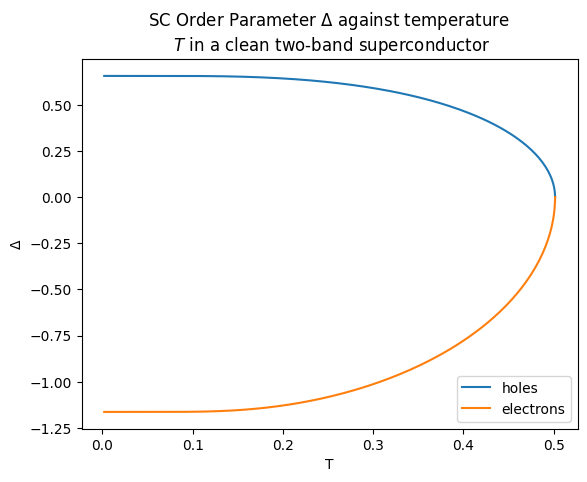

In [4]:
# trying
T = 0.6
out = Delta(T)
plt.plot(out[0], out[1][:,0], label = 'holes')
plt.plot(out[0], out[1][:,1], label = 'electrons')
plt.ylabel('$\Delta$')
plt.xlabel('T')
plt.title('SC Order Parameter $\Delta$ against temperature \n $T$ in a clean two-band superconductor')
plt.legend(loc = 'best')
plt.show()

## II. Evaluating $G(\omega_n)$ from Matsubara summation

In [4]:
# self-consistently solve for the tildes after guessing the untilded parameters
T_eval = 1e-2
Delta_h_init, Delta_e_init = initD # clean gap size
omega_eval = omegaMatsu(0, T_eval)
print('The tildes omega_n, Delta_h, Delta_e = ', f'{SigmaCorrections(omega_eval,Delta_h_init, Delta_e_init, 0.04)}', '\n', f'given untilted {omega_eval, Delta_h_init, Delta_e_init}')

The tildes omega_n, Delta_h, Delta_e =  [0.041654045009715195, 0.7460292907852083, -1.075047678386334] 
 given untilted (0.031415926535897934, np.float64(0.6570212873272268), np.float64(-1.1640556818443157))


In [5]:
# Use Matsubara Summation to calculate Chi(T, Gamma), SLOW! 
startT = time.time()
res = ChiMatsu(T_eval, Delta_h_init, Delta_e_init, 0.04)
endT = time.time()
print(f'A Single Matsubara summation over {max_it} points takes {(endT - startT):.5f} seconds')


A Single Matsubara summation over 10000 points takes 5.50696 seconds


In [6]:
# Find the order parameters from the gap equations.
ifSolveGap = True
if ifSolveGap:
    startT = time.time()
    res = SolveGap(initD,T_eval,0.04)
    endT = time.time()
    print(f'Solving the gap equations takes {(endT - startT):.5f} seconds')
    Delta_out , Tildes_total = res 
    np.savetxt('Tildes_total.txt',Tildes_total)
else:
    Tildes_total = np.loadtxt('Tildes_total.txt')
    Delta_out = np.array(unnormalised_Delta_from_tildes(Tildes_total[0],0.04))[1:]

Omega_Tilde = np.array([Tildes_total[i][0] for i in range(len(Tildes_total))])
Delta_h_Tilde = np.array([Tildes_total[i][1] for i in range(len(Tildes_total))])
Delta_e_Tilde = np.array([Tildes_total[i][2] for i in range(len(Tildes_total))])

Solving the gap equations takes 74.75594 seconds


In [7]:
# evaluate Green's function at Matsubara frequencies
omega = np.zeros(2*max_it)
for n in np.arange(-max_it,max_it):
    omega[n + max_it] = omegaMatsu(n,T_eval)
G_arr, Sigma_arr, Omega_Tilde, Delta_Tilde = G_and_Sigma(omega,Delta_out[0]*np.ones(len(omega)),Delta_out[1]*np.ones(len(omega)),0.04)

<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:30: SyntaxWarning: invalid escape sequence '\o'
<>:31: SyntaxWarning: invalid escape sequence '\S'
<>:38: SyntaxWarning: invalid escape sequence '\o'
<>:39: SyntaxWarning: invalid escape sequence '\S'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:30: SyntaxWarning: invalid escape sequence '\o'
<>:31: SyntaxWarning: invalid escape sequence '\S'
<>:38: SyntaxWarning: invalid escape sequence '\o'
<>:39: SyntaxWarning: invalid escape sequence '\S'
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_22472\1557771261.py:7: SyntaxWarning: invalid escape sequence '\o'
  axs[0].set_xlabel('$\omega_n$')
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_22472\1557771261.py:15: SyntaxWarning: invalid escape sequence '\o'
  axs[1].set_xlabel('$\omega_n$')
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_22472\1557771261.py:30: SyntaxWarning: invalid escape s

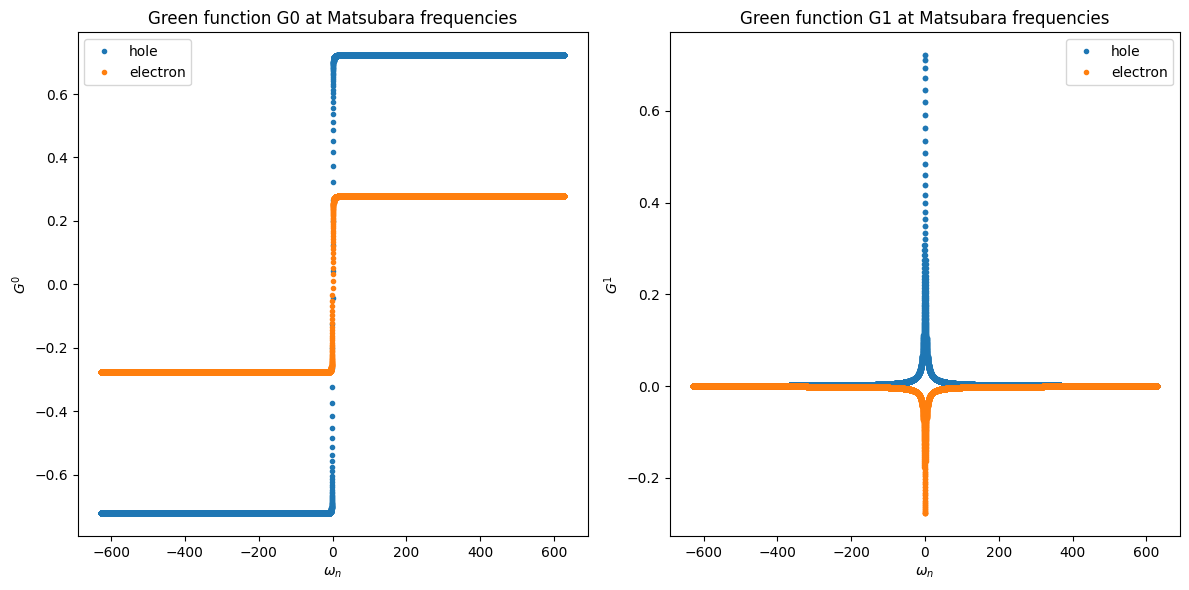

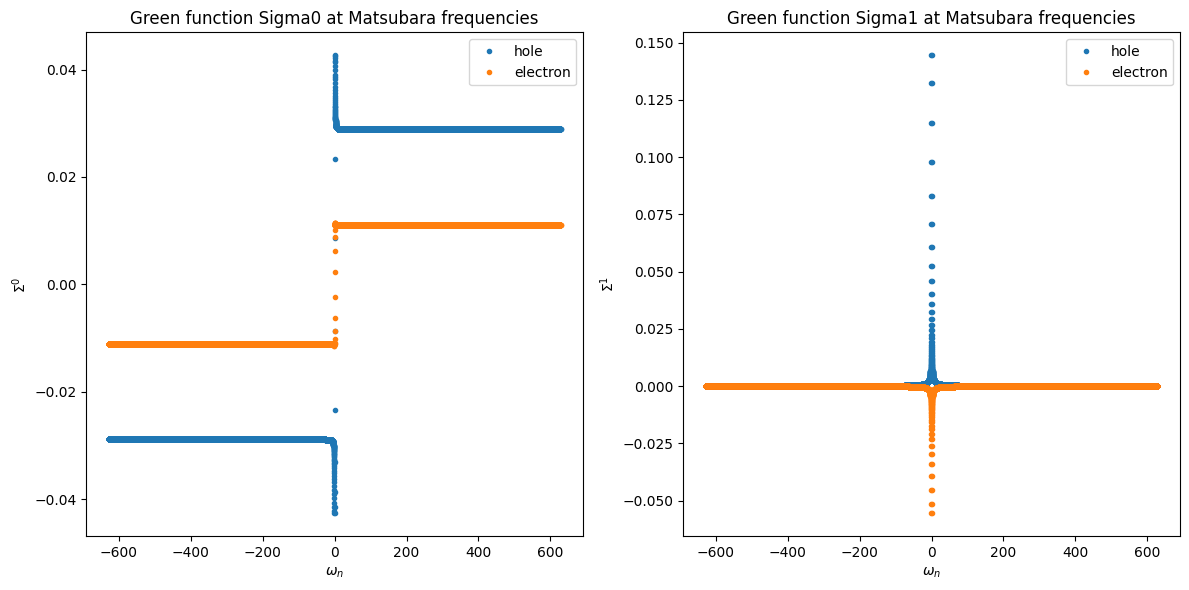

In [8]:
# plot the calculated Green's functions
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot
axs[0].plot(omega, G_arr[:,0,0], '.', label='hole')
axs[0].plot(omega, G_arr[:,1,0], '.', label='electron')
axs[0].set_xlabel('$\omega_n$')
axs[0].set_ylabel('$G^0$')
axs[0].set_title('Green function G0 at Matsubara frequencies')
axs[0].legend(loc='best')

# Second plot
axs[1].plot(omega, G_arr[:,0,1], '.', label='hole')
axs[1].plot(omega, G_arr[:,1,1], '.', label='electron')
axs[1].set_xlabel('$\omega_n$')
axs[1].set_ylabel('$G^1$')
axs[1].set_title('Green function G1 at Matsubara frequencies')
axs[1].legend(loc='best')

# Adjust layout
plt.tight_layout()
plt.show()

# plot the calculated self-energy
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot
axs[0].plot(omega, Sigma_arr[:,0,0], '.', label='hole')
axs[0].plot(omega, Sigma_arr[:,1,0], '.', label='electron')
axs[0].set_xlabel('$\omega_n$')
axs[0].set_ylabel('$\Sigma^0$')
axs[0].set_title('Green function Sigma0 at Matsubara frequencies')
axs[0].legend(loc='best')

# Second plot
axs[1].plot(omega, Sigma_arr[:,0,1], '.', label='hole')
axs[1].plot(omega, Sigma_arr[:,1,1], '.', label='electron')
axs[1].set_xlabel('$\omega_n$')
axs[1].set_ylabel('$\Sigma^1$')
axs[1].set_title('Green function Sigma1 at Matsubara frequencies')
axs[1].legend(loc='best')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
def ChiMatsu_test(temperature,Delta_h,Delta_e,Gamma):
    # test convergence in the Matsubara sum

    #This is actually analytically done, and it is the same as:
    ChiSubInt = lambda omega,Delta: 2*np.arctan(Omega_c/np.sqrt(omega**2+Delta**2))*Delta/np.sqrt(omega**2+Delta**2);



    ChiN_h =0; ChiN_e = 0;
    Chi_h = []; Chi_e=[]; Tildes_total = [];
    n=0;
    #The sum should go from -infty to infty

    for n in range(max_it):
        omega = omegaMatsu(n,temperature);
        #Find renormalised omega and Delta_h, Delta_e
        Tildes = SigmaCorrections(omega,Delta_h,Delta_e,Gamma);
        Tildes_total.append(Tildes)

        # Bang equation (10)
        Chi_h.append(temperature*ChiSubInt(Tildes[0],Tildes[1]));
        ChiN_h = ChiN_h + Chi_h[-1];

        Chi_e.append(temperature*ChiSubInt(Tildes[0],Tildes[2]));
        ChiN_e = ChiN_e + Chi_e[-1];

        n = n+1;



    return Chi_h, Chi_e, ChiN_h, ChiN_e, Tildes_total

In [ ]:
# test convergence of the Matsubara sum explicitly
Chi_h, Chi_e, _, _, _= ChiMatsu_test(T_eval, Delta_out[0],Delta_out[1], 0.04)
Chi_h_partial_sum = np.array([np.sum(Chi_h[:i]) for i in range(len(Chi_h))])
Chi_e_partial_sum = np.array([np.sum(Chi_h[:i]) for i in range(len(Chi_h))])

In [ ]:
plt.plot(np.log(Chi_h),'.')
plt.xlabel('Iter Num')
plt.ylabel('log(an)')
plt.show()

plt.plot(Chi_h_partial_sum,'.')
plt.xlabel('Iter Num')
plt.ylabel('Sn')
plt.show()

## III. Thermodynamic Calculation from Matsubara Summation

From path integral formalism, the free energy
$$ F = k_B T \sum_{\omega_n} \ln{\mathrm{det}(\mathcal{G}_\omega^{-1})} + F_0$$
where 

$$ 
\mathcal{G}_\omega = ( \mathcal{G}_h^0 (\mathbf{k}, i \omega_n) \qquad \mathcal{G}_h^1 (\mathbf{k}, i \omega_n) \\  \mathcal{G}_{e}^{1 \dagger} (\mathbf{k}, i \omega_n) \qquad \mathcal{G}_e^0 (\mathbf{k}, i \omega_n) )
$$

In [4]:
def detG_arr(G_arr, useAnomalous = True):
    # returns the determinant as if G_arr is a 2*2, not the Nambu 4*4 array
    detG = G_arr[:,0,0] * G_arr[:,1,0] - G_arr[:,0,1] * G_arr[:,1,1]
    if not(useAnomalous):
        detG =  G_arr[:,0,0] * G_arr[:,1,0]
    detG /= nh * ne # renormalise so it becomes 1 at high frequency
    return detG

def free_energy(G_arr, T, useAnomalous = True):
    # calculate free energy from Matsubara summation given G_arr at a given temperature
    detG = detG_arr(G_arr, useAnomalous)

    F = - T * np.sum(np.log(detG))
    return F

def free_energy_wrapper(T,Gamma,subfolder_name = ''):
    # self-consistently solve for Nambu-Gor'kov Green's function at a given temperature and impurity level, then calculate the free energy and save the data 
    T_eval = T
    # solve the gap equation
    startT = time.time()
    res = SolveGap(initD,T_eval,Gamma)
    endT = time.time()
    print(f'Solving the gap equations at T = {T} and Gamma = {Gamma} takes {(endT - startT):.5f} seconds')
    Delta_out , Tildes_total = res 
    if len(subfolder_name) > 0: # save the data
        directory = subfolder_name + '/'
    else:
        directory = subfolder_name
    saveName = directory + f'T{T:.3f}_Gamma{Gamma:.3f}_Tildes_total.npy'  
    np.save(saveName,Tildes_total)

    # evaluate Green's function at Matsubara frequencies
    omega = np.zeros(2*max_it)
    for n in np.arange(-max_it,max_it):
        omega[n + max_it] = omegaMatsu(n,T_eval)
    G_arr, Sigma_arr, Omega_Tilde, Delta_Tilde = G_and_Sigma(omega,Delta_out[0]*np.ones(len(omega)),Delta_out[1]*np.ones(len(omega)),Gamma) 

    saveName = directory + f'T{T:.3f}_Gamma{Gamma:.3f}_G_arr.npy'  
    np.save(saveName,G_arr) 

    return free_energy(G_arr, T_eval)

def unnormalised_Delta_from_tildes(tildes, Gamma):
    # return Delta_e and Delta_h from a N*3 array of [omega_tilde, Deltatilde_h, Deltatilde_e] under impurity level Gamma
    omega_tilde, Deltatilde_h, Deltatilde_e = tildes
    Delta_h = Deltatilde_h - sigma_h_1(tildes, Gamma) - sigma_e_1(tildes, Gamma)
    Delta_e = Deltatilde_e - sigma_h_1(tildes, Gamma) - sigma_e_1(tildes, Gamma) 
    omega_n = omega_tilde - sigma_h_0(tildes, Gamma) - sigma_h_0(tildes, Gamma)
    return omega_n, Delta_h, Delta_e 

def numerical_derivative(y,x):
    """
    Compute the derivative of y with respect to x using finite difference method.
    
    Parameters:
    - x: array-like, shape (n,)
    - y: array-like, shape (n,)
    
    Returns:
    - dy_dx: array-like, shape (n,), the derivative dy/dx
    """
    x = np.asarray(x)
    y = np.asarray(y)
    dy_dx = np.zeros_like(y)

    # Central difference for interior points
    dy_dx[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])

    # Forward/backward difference for boundary points
    dy_dx[0] = (y[1] - y[0]) / (x[1] - x[0])
    dy_dx[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])

    return dy_dx

def heat_capacity_F(F_arr, T_arr):
    # calculate the heat capacity given free energy array and temperature array
    U = - T_arr**2* numerical_derivative(F_arr / T_arr, T_arr)
    C = numerical_derivative(U, T_arr)
    return C 

def load_results(T, Gamma, directory, mustContain=''):
    """
    Load specific .npy files from a directory based on provided temperature (T) and gamma (Gamma) values.

    This function searches a specified directory for .npy files that follow a naming convention containing 
    'T{T_value}_G{Gamma_value}_G_arr.npy' or 'T{T_value}_G{Gamma_value}_Tildes_total.npy'. It identifies the files 
    whose names contain T_value closest to the provided T and Gamma_value closest to the provided Gamma. An optional 
    argument allows users to filter files that must include a specific string in their names. The function assumes 
    there are exactly two matching files in the directory: one containing 'G_arr' and one containing 'Tildes_total'. 
    It loads and returns the stored arrays from these files.

    Parameters:
    -----------
    T : float
        The target temperature value to match in the filenames.

    Gamma : float
        The target gamma value to match in the filenames.

    directory : str
        The directory path where the .npy files are located.

    mustContain : str, optional
        A string that the filenames must contain to be considered (default is '').

    Returns:
    --------
    G_arr : numpy.ndarray
        The array loaded from the file containing 'G_arr' in its name.

    Tildes_total : numpy.ndarray
        The array loaded from the file containing 'Tildes_total' in its name.

    Raises:
    -------
    FileNotFoundError
        If the function cannot find exactly two matching files for the specified T and Gamma values.

    Examples:
    ---------
    >>> directory_path = '/path/to/your/directory'
    >>> T = 0.052
    >>> Gamma = 0.0
    >>> mustContain = ''  # Optional string filtering
    >>> G_arr, Tildes_total = load_results(T, Gamma, directory_path, mustContain)
    >>> print("Loaded G_arr shape:", G_arr.shape)
    >>> print("Loaded Tildes_total shape:", Tildes_total.shape)
    """
    # List all files in the directory
    files = os.listdir(directory)
    
    # Filter files by those containing mustContain string
    if mustContain:
        files = [f for f in files if mustContain in f]
    
    # Initialize variables to store closest matches
    closest_G_arr_file = None
    closest_Tildes_total_file = None
    min_combined_diff_G_arr = float('inf')
    min_combined_diff_Tildes_total = float('inf')
    
    # Iterate over files to find closest T and Gamma matches
    for filename in files:
        if filename.endswith('.npy'):
            if 'G_arr' in filename or 'Tildes_total' in filename:
                # Extract T_value and Gamma_value from the filename
                parts = filename.split('_')
                T_value = None
                Gamma_value = None
                for part in parts:
                    if part.startswith('T0'):
                        T_value = float(part[1:])
                    elif part.startswith('Gamma'):
                        Gamma_value = float(part[5:])
                
                # Skip files that do not have valid T or Gamma values
                if T_value is None or Gamma_value is None:
                    continue
                
                # Calculate combined difference with requested T and Gamma
                combined_diff = abs(T_value - T) + abs(Gamma_value - Gamma)
                
                # Update closest files based on the combined difference
                if 'G_arr' in filename and combined_diff < min_combined_diff_G_arr:
                    closest_G_arr_file = filename
                    min_combined_diff_G_arr = combined_diff
                if 'Tildes_total' in filename and combined_diff < min_combined_diff_Tildes_total:
                    closest_Tildes_total_file = filename
                    min_combined_diff_Tildes_total = combined_diff
    
    # Check if both closest files are found
    if closest_G_arr_file is None or closest_Tildes_total_file is None:
        raise FileNotFoundError(f"Could not find matching files for T={T} and Gamma={Gamma} in directory '{directory}'")
    
    # Load the arrays from the found files
    G_arr = np.load(os.path.join(directory, closest_G_arr_file))
    Tildes_total = np.load(os.path.join(directory, closest_Tildes_total_file))
    
    print(closest_G_arr_file)
    return G_arr, Tildes_total
"""
def G_free(omega_n, Delta_h, Delta_e):
    # calculate the free Green's function from unnormalised parameters
    G_h_0_free = nh * omega_n / np.sqrt(omega_n**2 + Delta_h**2)
    G_h_1_free = nh * Delta_h / np.sqrt(omega_n**2 + Delta_h**2)
    G_e_0_free = ne * omega_n / np.sqrt(omega_n**2 + Delta_e**2)
    G_e_1_free = ne * Delta_e / np.sqrt(omega_n**2 + Delta_e**2)

    Gout = np.array([[G_h_0_free, G_h_1_free],[ G_e_0_free, G_e_1_free]])
    return Gout 

def detG_arr_naive_renormalised(G_arr, Tildes_total, Gamma):
    # returns the determinant at all Matsubara frequencies as if G_arr is a 2*2, not the Nambu 4*4 array, renormalised with respect to the free Green's function
    detG = G_arr[:,0,0] * G_arr[:,1,0] - G_arr[:,0,1] * G_arr[:,1,1]
    G0 = np.zeros(np.shape(G_arr))
    for i in range(np.shape(G_arr)[0]):
        Tildes = Tildes_total[i,:]
        unnormalised = unnormalised_Delta_from_tildes(Tildes, Gamma)
        G0[i] = G_free(unnormalised[0], unnormalised[1], unnormalised[2])
    detG0 = G0[:,0,0] * G0[:,1,0] - G0[:,0,1] * G0[:,1,1]
    return detG / detG0

def free_energy_naive_renormalised(G_arr, Tildes_total, T, Gamma):
    # calculate free energy from Matsubara summation given G_arr at a given temperature
    detG = detG_arr_naive_renormalised(G_arr, Tildes_total, Gamma)
    F = - T * np.sum(np.log(np.abs(detG[0])))
    return F
"""

""" 
ONE TIME USE. The script has been executed. 
Re-order all G_arr files so that they run from negative frequency to positive frequency instead of the other way around

def reorder(G_arr_test):
    # re-order from the positive then negative frequency convention to negative then positive frequency convention
    G_arr_test_reordered = np.zeros(np.shape(G_arr_test))
    G_arr_test_reordered[:max_it,:,:] = G_arr_test[max_it:,:,:]
    G_arr_test_reordered[max_it:,:,:] = G_arr_test[:max_it,:,:]
    return G_arr_test_reordered

# Define the directory where your .npy files are stored
directory = 'data'

# Iterate over all files in the directory
for filename in os.listdir(directory):
    # Check if the filename contains 'G_arr' and ends with .npy
    if 'G_arr' in filename and filename.endswith('.npy'):
        filepath = os.path.join(directory, filename)
        # Load the .npy file
        G_arr = np.load(filepath)
        # Reorder the array
        G_arr_reordered = reorder(G_arr)
        # Save the reordered array back to the same file, overwriting it
        np.save(filepath, G_arr_reordered)
"""

" \nONE TIME USE. The script has been executed. \nRe-order all G_arr files so that they run from negative frequency to positive frequency instead of the other way around\n\ndef reorder(G_arr_test):\n    # re-order from the positive then negative frequency convention to negative then positive frequency convention\n    G_arr_test_reordered = np.zeros(np.shape(G_arr_test))\n    G_arr_test_reordered[:max_it,:,:] = G_arr_test[max_it:,:,:]\n    G_arr_test_reordered[max_it:,:,:] = G_arr_test[:max_it,:,:]\n    return G_arr_test_reordered\n\n# Define the directory where your .npy files are stored\ndirectory = 'data'\n\n# Iterate over all files in the directory\nfor filename in os.listdir(directory):\n    # Check if the filename contains 'G_arr' and ends with .npy\n    if 'G_arr' in filename and filename.endswith('.npy'):\n        filepath = os.path.join(directory, filename)\n        # Load the .npy file\n        G_arr = np.load(filepath)\n        # Reorder the array\n        G_arr_reordered = r

In [6]:
# calculate free energy at different temperature and impurity level. Takes ~3 hours
Gamma_arr = np.array([0,0.01,0.04,0.08])
T_arr = np.linspace(Tmin, 0.45, 64)
F_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
for i in range(np.size(Gamma_arr)):
    for j in range(np.size(T_arr)):
        Gamma = Gamma_arr[i]
        T_eval = T_arr[j]
        F_arr[i,j] = free_energy_wrapper(T_eval,Gamma, subfolder_name='data')


Solving the gap equations at T = 0.002 and Gamma = 0.0 takes 62.24915 seconds
Solving the gap equations at T = 0.009111111111111111 and Gamma = 0.0 takes 55.68248 seconds
Solving the gap equations at T = 0.01622222222222222 and Gamma = 0.0 takes 55.22362 seconds
Solving the gap equations at T = 0.023333333333333338 and Gamma = 0.0 takes 55.09821 seconds
Solving the gap equations at T = 0.030444444444444448 and Gamma = 0.0 takes 50.40816 seconds
Solving the gap equations at T = 0.03755555555555556 and Gamma = 0.0 takes 50.79790 seconds
Solving the gap equations at T = 0.044666666666666674 and Gamma = 0.0 takes 51.98376 seconds
Solving the gap equations at T = 0.051777777777777784 and Gamma = 0.0 takes 50.83641 seconds
Solving the gap equations at T = 0.05888888888888889 and Gamma = 0.0 takes 50.88298 seconds
Solving the gap equations at T = 0.066 and Gamma = 0.0 takes 50.93152 seconds
Solving the gap equations at T = 0.07311111111111111 and Gamma = 0.0 takes 61.11990 seconds
Solving the

c:\Users\tcsxx\OneDrive - University of Cambridge\2024 QM Summer Project\Superconductivity_numerics\Max Python Scripts\gapeqn_library.py:202: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  TildesOut = fsolve(Eqn,[omega,Delta_h,Delta_e],xtol=1e-12);


Solving the gap equations at T = 0.002 and Gamma = 0.01 takes 78.87996 seconds
Solving the gap equations at T = 0.009111111111111111 and Gamma = 0.01 takes 69.93217 seconds
Solving the gap equations at T = 0.01622222222222222 and Gamma = 0.01 takes 86.98128 seconds
Solving the gap equations at T = 0.023333333333333338 and Gamma = 0.01 takes 69.51479 seconds
Solving the gap equations at T = 0.030444444444444448 and Gamma = 0.01 takes 63.74958 seconds
Solving the gap equations at T = 0.03755555555555556 and Gamma = 0.01 takes 63.92988 seconds
Solving the gap equations at T = 0.044666666666666674 and Gamma = 0.01 takes 63.63269 seconds
Solving the gap equations at T = 0.051777777777777784 and Gamma = 0.01 takes 63.85324 seconds
Solving the gap equations at T = 0.05888888888888889 and Gamma = 0.01 takes 63.61652 seconds
Solving the gap equations at T = 0.066 and Gamma = 0.01 takes 63.80020 seconds
Solving the gap equations at T = 0.07311111111111111 and Gamma = 0.01 takes 63.58561 seconds


c:\Users\tcsxx\OneDrive - University of Cambridge\2024 QM Summer Project\Superconductivity_numerics\Max Python Scripts\gapeqn_library.py:151: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  DeltaOut = fsolve(wrapper_SelfConsEqn,Delta0,xtol=1e-13);


Solving the gap equations at T = 0.4428888888888889 and Gamma = 0.08 takes 679.16311 seconds
Solving the gap equations at T = 0.45 and Gamma = 0.08 takes 524.61382 seconds


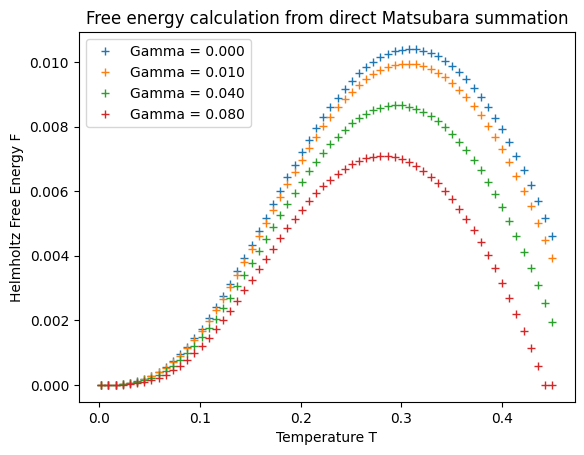

In [8]:
for i in range(np.size(Gamma_arr)):
    plt.plot(T_arr, F_arr[i,:],'+',label = f'Gamma = {Gamma_arr[i]:.3f}')
plt.xlabel('Temperature T')
plt.ylabel('Helmholtz Free Energy F')
plt.legend(loc = 'best')
plt.title('Free energy calculation from direct Matsubara summation')
plt.show()


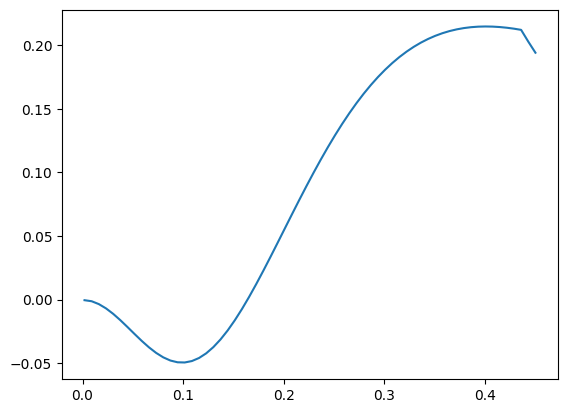

In [22]:
U = - T_arr**2* numerical_derivative(F_arr[0,:] / T_arr, T_arr)
C = numerical_derivative(U, T_arr)
plt.plot(T_arr, C)
plt.show()

T0.002_Gamma0.000_G_arr.npy
T0.009_Gamma0.000_G_arr.npy
T0.016_Gamma0.000_G_arr.npy
T0.023_Gamma0.000_G_arr.npy
T0.030_Gamma0.000_G_arr.npy
T0.038_Gamma0.000_G_arr.npy
T0.045_Gamma0.000_G_arr.npy
T0.052_Gamma0.000_G_arr.npy
T0.059_Gamma0.000_G_arr.npy
T0.066_Gamma0.000_G_arr.npy
T0.073_Gamma0.000_G_arr.npy
T0.080_Gamma0.000_G_arr.npy
T0.087_Gamma0.000_G_arr.npy
T0.094_Gamma0.000_G_arr.npy
T0.102_Gamma0.000_G_arr.npy
T0.109_Gamma0.000_G_arr.npy
T0.116_Gamma0.000_G_arr.npy
T0.123_Gamma0.000_G_arr.npy
T0.130_Gamma0.000_G_arr.npy
T0.137_Gamma0.000_G_arr.npy
T0.144_Gamma0.000_G_arr.npy
T0.151_Gamma0.000_G_arr.npy
T0.158_Gamma0.000_G_arr.npy
T0.166_Gamma0.000_G_arr.npy
T0.173_Gamma0.000_G_arr.npy
T0.180_Gamma0.000_G_arr.npy
T0.187_Gamma0.000_G_arr.npy
T0.194_Gamma0.000_G_arr.npy
T0.201_Gamma0.000_G_arr.npy
T0.208_Gamma0.000_G_arr.npy
T0.215_Gamma0.000_G_arr.npy
T0.222_Gamma0.000_G_arr.npy
T0.230_Gamma0.000_G_arr.npy
T0.237_Gamma0.000_G_arr.npy
T0.244_Gamma0.000_G_arr.npy
T0.251_Gamma0.000_G_

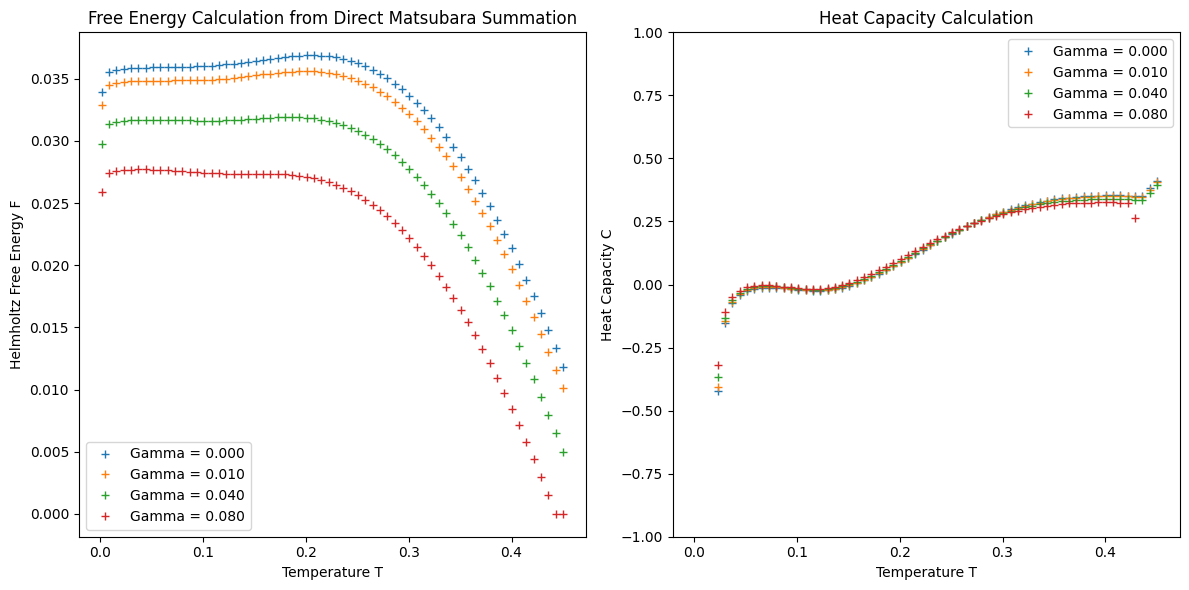

In [12]:
# Define the directory where your .npy files are stored
directory = 'data'

# calculate free energy at different temperature and impurity level
Gamma_arr = np.array([0,0.01,0.04,0.08])
T_arr = np.linspace(Tmin, 0.45, 64)
F_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
C_arr = np.zeros((np.size(Gamma_arr),np.size(T_arr)))
for i in range(np.size(Gamma_arr)):
    for j in range(np.size(T_arr)):
        Gamma = Gamma_arr[i]
        T_eval = T_arr[j]
        G_arr, Tildes_total = load_results(T_eval, Gamma, directory)
        F_arr[i,j] = free_energy(G_arr, T_eval)
for i in range(np.size(Gamma_arr)):
    Gamma = Gamma_arr[i]
    C_arr[i,:] = heat_capacity_F(F_arr[i,:], T_arr)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot F_arr against T on the first subplot
for i in range(np.size(Gamma_arr)):
    axes[0].plot(T_arr, F_arr[i, :], '+', label=f'Gamma = {Gamma_arr[i]:.3f}')
axes[0].set_xlabel('Temperature T')
axes[0].set_ylabel('Helmholtz Free Energy F')
axes[0].legend(loc='best')
axes[0].set_title('Free Energy Calculation from Direct Matsubara Summation')

# Plot C_arr (heat capacity) against T on the second subplot
for i in range(np.size(Gamma_arr)):
    axes[1].plot(T_arr, C_arr[i, :], '+', label=f'Gamma = {Gamma_arr[i]:.3f}')
axes[1].set_xlabel('Temperature T')
axes[1].set_ylabel('Heat Capacity C')
axes[1].legend(loc='best')
axes[1].set_title('Heat Capacity Calculation')
axes[1].set_ylim(-1,1)
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

T0.102_Gamma0.000_G_arr.npy
T0.286_Gamma0.000_G_arr.npy
T0.450_Gamma0.000_G_arr.npy
T0.450_Gamma0.000_G_arr.npy


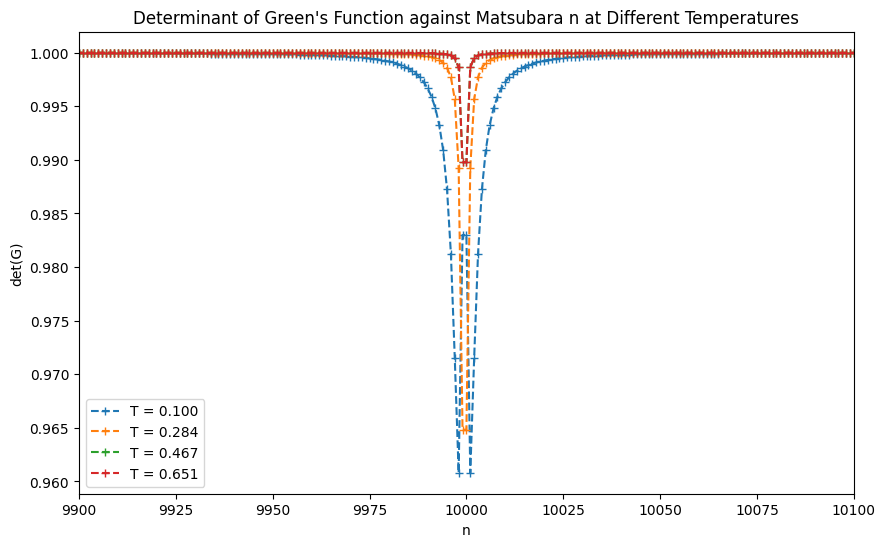

In [13]:

directory = 'data'
Gamma = 0
T_arr = np.linspace(0.1, 1.0, 50)  # Example temperature array

# Temperatures to plot
selected_indices = [0, 10, 20, 30]
selected_temperatures = [T_arr[i] for i in selected_indices]

plt.figure(figsize=(10, 6))

# Load results and plot for each selected temperature
for temp in selected_temperatures:
    G_arr, Tildes_total = load_results(temp, Gamma, directory)
    det_G = detG_arr(G_arr)
    plt.plot(det_G, '+--', label=f'T = {temp:.3f}')

plt.xlabel('n')
plt.ylabel('det(G)')
plt.title("Determinant of Green's Function against Matsubara n at Different Temperatures")
plt.xlim(9900, 10100)
plt.legend(loc='best')
plt.show()

#### Discussion
Doesn't make sense at all with a negative heat capacity and free energy. However, the sum is valid, as it shows that under low temperature there are more points contributing from the Matsubara summation, composating for a smaller $T.$ 

## IV. Single-band superconductor Calculation
Calculate the heat capacity for a single-band superconductor

## IV. Pade Approximation and Analytic Continuation

In [ ]:
# repeat the process of finding the Green's function
# self-consistently solve for the tildes after guessing the untilded parameters
T_eval = 1e-2
Delta_h_init, Delta_e_init = initD # clean gap size

# Find the order parameters from the gap equations.
ifSolveGap = False
if ifSolveGap:
    startT = time.time()
    res = SolveGap(initD,T_eval,0.04)
    endT = time.time()
    print(f'Solving the gap equations takes {(endT - startT):.5f} seconds')
    Delta_out , Tildes_total = res 
    np.savetxt('Tildes_total.txt',Tildes_total)
else:
    Tildes_total = np.loadtxt('Tildes_total.txt')
    Delta_out = np.array(unnormalised_Delta_from_tildes(Tildes_total[0],0.04))[1:]

Omega_Tilde = np.array([Tildes_total[i][0] for i in range(len(Tildes_total))])
Delta_h_Tilde = np.array([Tildes_total[i][1] for i in range(len(Tildes_total))])
Delta_e_Tilde = np.array([Tildes_total[i][2] for i in range(len(Tildes_total))])

# evaluate Green's function at Matsubara frequencies
omega = np.zeros(2*max_it)
for n in np.arange(-max_it,max_it):
    omega[n+ max_it] = omegaMatsu(n,T_eval)
G_arr, Sigma_arr, Omega_Tilde, Delta_Tilde = G_and_Sigma(omega,Delta_out[0]*np.ones(len(omega)),Delta_out[1]*np.ones(len(omega)),0.04)

In [ ]:
# testing the Pade approximation
def f(z):
    return np.tanh(z)
z_arr = np.linspace(-5,5,100)
f_arr = f(z_arr)

z_fine = np.linspace(-5,5,100)*1j
f_eval = pade(z_fine,z_arr,f_arr)

plt.plot(z_arr, np.tan(z_arr), '+')
plt.plot(np.imag(z_fine), np.imag(f_eval), '--')
plt.show()

In [ ]:
a_test = padecoeffs(omega, G_arr[:,0,0])

In [ ]:
G_h_imag = padeeval(w_imag,omega,a_test) # analytic continuation to the imaginary axis
G_e_imag = 0

DoS = -Ntot*np.real(G_h_imag+G_e_imag)/(np.pi*Ntot)

omega_real_fine = np.linspace(-100,100,5000) # plot on the real axis to test Pade approximation
G_h_real = padeeval(omega, omega, a_test)

In [ ]:
# Assuming G_arr and omega are already defined
N_sample = 100 # too high -> amplitude of oscillation at large frequency at large, too low -> bad convergence hence get spikes N = 150 seems like a good balance
omega_matsu_cutoff = 15 * Omega_c
central_omega = 0.4 * Omega_c

# Split omega and G_arr into regions
central_region_mask = np.abs(omega) <= central_omega
outer_region_mask = (np.abs(omega) > central_omega) & (np.abs(omega) < omega_matsu_cutoff)

# Extract the indices for central and outer regions
central_indices = np.where(central_region_mask)[0]
outer_indices = np.where(outer_region_mask)[0]

# Perform uniform random sampling without replacement for each region
central_sample_indices = random.sample(list(central_indices), N_sample // 2)
outer_sample_indices = random.sample(list(outer_indices), N_sample // 2)

# Combine samples and indices
indices_sample = np.concatenate((central_sample_indices, outer_sample_indices))
G_arr_sample = G_arr[indices_sample, 0, 0]

# Extract the corresponding omega samples
omega_sample = omega[indices_sample]

# Plot the sampled data
plt.plot(omega_sample, G_arr_sample, '+')

# Generate a finer omega sample for fitting
omega_sample_finer = np.linspace(-15*Omega_c, 15*Omega_c, 2000)
G_fit_sampled = pade(omega_sample_finer, omega_sample, G_arr_sample)
plt.plot(omega_sample_finer, G_fit_sampled, '--')
plt.ylim(-2,2)

plt.xlabel('omega')
plt.ylabel('G_h_0 on real')
plt.show()

# Generate a finer omega sample for fitting
delta = -0.5
omega_sample_finer = np.linspace(-Omega_c, Omega_c, 2000)*1j + 10**(delta)
G_fit_sampled = pade(omega_sample_finer, omega_sample, G_arr_sample)
plt.plot(np.imag(omega_sample_finer), np.real(G_fit_sampled), label = 'Re(G)')
plt.plot(np.imag(omega_sample_finer), np.imag(G_fit_sampled), label = 'Im(G)')
plt.xlabel('Im(omega)')
plt.ylabel('Analytically continued G_h_0 on imaginary axis')
plt.legend(loc = 'best')
plt.show()

In [ ]:
plt.plot(np.imag(w_imag),np.abs(G_h_imag),'+') # delta = 10^-1.1
plt.xlabel('$\omega$')
plt.ylabel('Hole density of states')
plt.show()